# Ames Housing Prices

## Purpose of the Analysis:

### Find out which Variables Strongly Affect the Housing Prices

The goal of this project is to determine which variables most strongly correlate to the determination of the housing prices in Ames, Iowa. After conducting EDA, multi linear regression is conducted on the data. The loss from our chosen loss fuction, RMSE, will be compared to each iteration of the regression further improve the model.

This project is an extension to one of the labs in the DATA 200 course at UC Berkeley. Some of the code of the beginning draws directly from the notebook, which will be noted in the markdown.

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
from sklearn.model_selection import KFold
from sklearn.base import clone
import os

default_path='/Users/bench/Documents/Python Scripts/Ames Housing'
os.chdir(default_path)

training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

## EDA

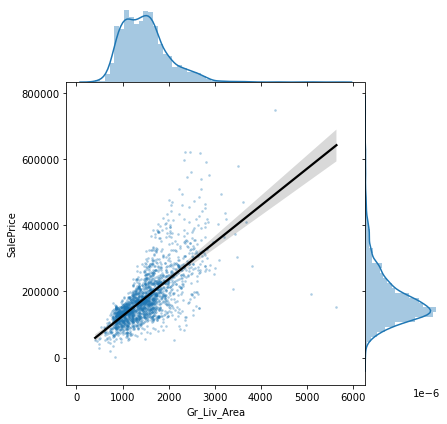

In [3]:
training_data.columns.values

sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
    stat_func=None,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
);

In [4]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than or equal to this will be removed
    
    Output:
      a winsorized data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data.loc[(data[variable] > lower) & (data[variable] < upper), :]
training_data = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

In [ ]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    """
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    with_bathrooms['TotalBathrooms']=with_bathrooms[bath_vars].fillna(0)@weights
    return with_bathrooms

training_data = add_total_bathrooms(training_data)

In [ ]:
noise = np.random.normal(0,0.5,1998)
training_data_2=training_data
training_data_2['TotalBathrooms']=training_data_2['TotalBathrooms']+noise
sns.scatterplot(data=training_data_2,x='TotalBathrooms',y='SalePrice')

In [ ]:
full_data = pd.read_csv("ames_train.csv")
full_data_len = len(full_data)
full_data.head()

train,val=train_test_split(full_data,test_size=0.2,random_state=42)

In [ ]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Transform Data, Select Features
    data = add_total_bathrooms(data)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

X_train, y_train = process_data_gm(train)
X_val, y_val = process_data_gm(val)


linear_model = lm.LinearRegression(fit_intercept=True)
linear_model.fit(X_train,y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_val)

In [ ]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array): vector of actual values
      predicted (1D array): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual-predicted)**2))

training_error = rmse(y_train, y_fitted)
val_error = rmse(y_val, y_predicted)
(training_error, val_error)

residuals = y_val - y_predicted
ax = sns.regplot(y_val, residuals)
ax.set_xlabel('Sale Price (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. Sale Price on Validation Data");

In [ ]:
training_data = pd.read_csv("ames_train_cleaned.csv")

def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood').agg(metric).sort_values('SalePrice',ascending=False).iloc[0:n].index.tolist()
    return neighborhoods

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data['in_rich_neighborhood'] = data['Neighborhood'].isin(neighborhoods).astype('category')
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)
training_data

missing_counts = np.sum(training_data.isnull(),axis=0).sort_values(ascending=False)
missing_counts

def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    data['Fireplace_Qu']=data['Fireplace_Qu'].replace({'Ex':'Excellent','Gd':'Good','TA':'Average','Fa':'Fair','Po':'Poor',np.nan:'No Fireplace'})
    return data
    
training_data = fix_fireplace_qu(training_data)
training_data

def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form Fireplace_Qu=QUALITY
    """
    vec_enc = DictVectorizer()
    vec_enc.fit(data[['Fireplace_Qu']].to_dict(orient='records'))
    fireplace_qu_data = vec_enc.transform(data[['Fireplace_Qu']].to_dict(orient='records')).toarray()
    fireplace_qu_cats = vec_enc.get_feature_names()
    fireplace_qu = pd.DataFrame(fireplace_qu_data, columns=fireplace_qu_cats)
    data = pd.concat([data, fireplace_qu], axis=1)
    data = data.drop(columns=fireplace_qu_cats[0])
    return data

training_data = ohe_fireplace_qu(training_data)

training_data = pd.read_csv("ames_train_cleaned.csv")

def process_data_gm(data):
    """Process the data for a guided model."""
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'Fireplace_Qu=Excellent',
                          'Fireplace_Qu=Fair',
                          'Fireplace_Qu=Good',
                          'Fireplace_Qu=No Fireplace',
                          'Fireplace_Qu=Poor'
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

X_train_gm, y_train_gm = process_data_gm(training_data)
X_train_gm.head()

linear_model_gm = lm.LinearRegression(fit_intercept=True)

# Fit the model
linear_model_gm.fit(X_train_gm, y_train_gm)

# Compute the fitted and predicted values of SalePrice
y_fitted_gm = linear_model_gm.predict(X_train_gm)

training_error_gm = rmse(y_fitted_gm, y_train_gm)
print("Training RMSE: {}".format(training_error_gm))

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

cv_error_gm = cross_validate_rmse(linear_model_gm,X_train_gm,y_train_gm)
print("Cross Validation RMSE: {}".format(cv_error_gm))

test_data.drop(test_data[test_data['Garage_Area'].isnull()].index)

final_model = lm.LinearRegression(fit_intercept=True) 

def process_data_fm(data):
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    data=data.drop(data[data['Garage_Area'].isnull()].index)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'Fireplace_Qu=Excellent',
                          'Fireplace_Qu=Fair',
                          'Fireplace_Qu=Good',
                          'Fireplace_Qu=No Fireplace',
                          'Fireplace_Qu=Poor'
                         )
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    return X, y


training_data = pd.read_csv('ames_train_cleaned.csv')
test_data = pd.read_csv('ames_test_cleaned.csv')

X_train, y_train = process_data_fm(training_data)
X_test, y_test = process_data_fm(test_data)

final_model.fit(X_train, y_train)
y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

training_rmse = rmse(y_predicted_train, y_train)
test_rmse = rmse(y_predicted_test, y_test)
(training_rmse,test_rmse)